In [32]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Kishor@2003',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/kishor/OneDrive/Documents/GitHub pro/Ecommerce/Ecommrece-kaggle-datasets'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Kishor@2003",
                             database = "ecommerce")
cur = db.cursor()



In [56]:
#q1.List all unique cities where customers are located.
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

data[:10]

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',)]

In [3]:
#Count the number of orders placed in 2017.
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

data


[(90202,)]

In [8]:
#Calculate the percentage of orders that were paid in installments.
query = """ select (sum(case when payment_installments >= 1 then 1
            else 0 end))/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

data
print('the percentage of orders that were paid in installments is',data[0][0])

the percentage of orders that were paid in installments is 99.9981


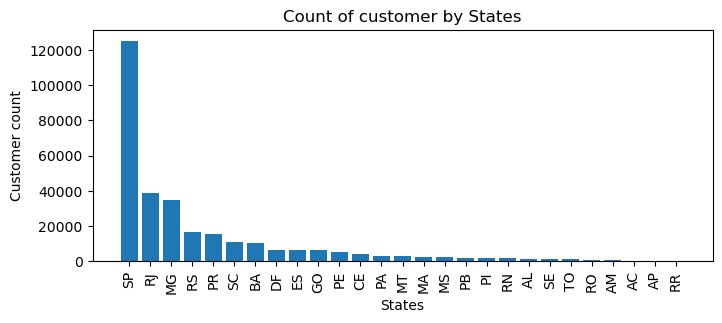

In [43]:
#Count the number of customers from each state.
query = """ select customer_state,count(customer_id)
            from customers
            group by customer_state
            """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State","customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["State"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Customer count")
plt.title("Count of customer by States")
plt.show()

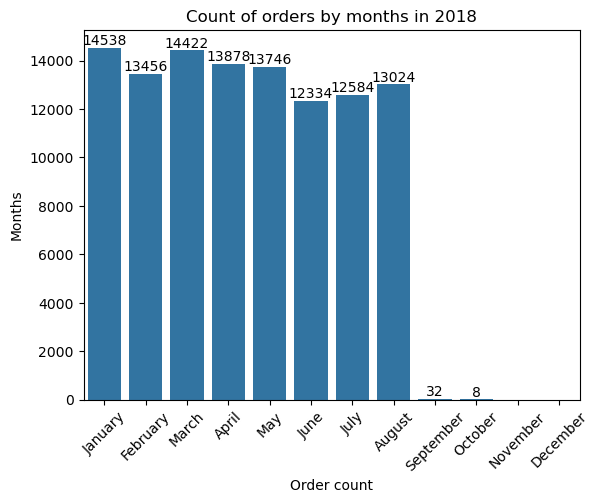

In [45]:
# Calculate the number of orders per month in 2018.
query = """ select monthname(order_purchase_timestamp) months,
            count(order_id) order_count
            from orders where year(order_purchase_timestamp)=2018
            group by months"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months","order_count"])
'''print(data)
print(df)'''

o = ["January","February","March","April","May","June",
     "July","August","September","October","November","December"]


ax=sns.barplot(x="months",y="order_count",data=df,order=o)


plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.xlabel("Order count")
plt.ylabel("Months")
plt.title("Count of orders by months in 2018")
plt.show()


In [52]:
#Find the average number of products per order, grouped by customer city.
query = """ SELECT 
    customers.customer_city,
    ROUND(AVG(t.oc), 2) AS average_orders
FROM customers
LEFT JOIN (
    SELECT 
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items
        ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
) t
ON customers.customer_id = t.customer_id
GROUP BY customers.customer_city;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city","average products/order"])
df.head(10)


,customer city,average orders
0,franca,None
1,sao bernardo do campo,None
2,sao paulo,None
3,mogi das cruzes,None
4,campinas,None
5,jaragua do sul,None
6,timoteo,None
7,curitiba,None
8,belo horizonte,None
9,montes claros,None


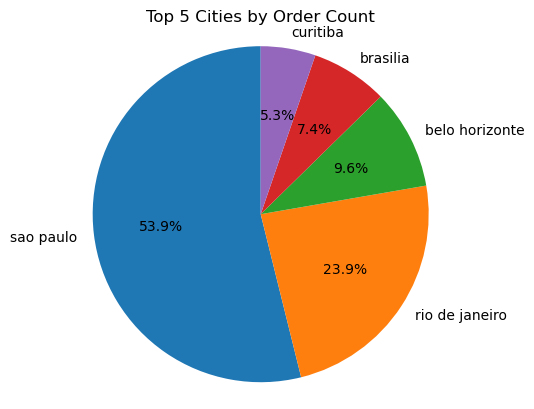

In [14]:
query = """
SELECT 
    c.customer_city,
    COUNT(o.order_status) AS order_count
FROM customers c
LEFT JOIN orders o
    ON c.customer_id = o.customer_id
GROUP BY c.customer_city
ORDER BY order_count DESC
LIMIT 5;
"""

cur.execute(query)
data = cur.fetchall()

cities = [row[0] for row in data]
order_counts = [row[1] for row in data]

plt.pie(order_counts, labels=cities, autopct="%1.1f%%", startangle=90)
plt.title("Top 5 Cities by Order Count")
plt.axis("equal")
plt.show()




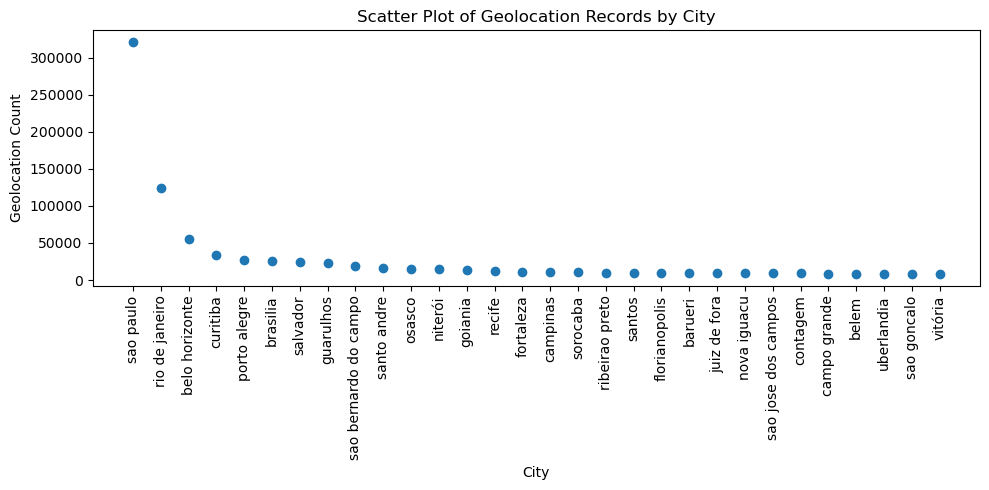

In [18]:
query = """ SELECT count(*),geolocation_city 
FROM ecommerce.geolocation
group by geolocation_city
order by count(*) desc
limit 30;"""

cur.execute(query)

data = cur.fetchall()
counts = [row[0] for row in data]
cities = [row[1] for row in data]
x = list(range(len(cities))) 

plt.figure(figsize=(10, 5))

plt.scatter(x, counts)
plt.xticks(x, cities, rotation=90)
plt.xlabel("City")
plt.ylabel("Geolocation Count")
plt.title("Scatter Plot of Geolocation Records by City")

plt.tight_layout()
plt.show()


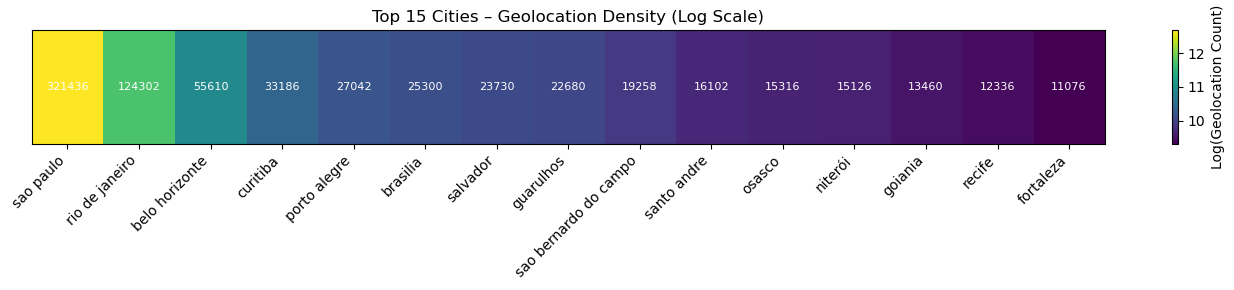

In [21]:
import numpy as np
query = """ SELECT count(*),geolocation_city 
FROM ecommerce.geolocation
group by geolocation_city
order by count(*) desc
limit 30;"""

cur.execute(query)

data = cur.fetchall()
counts = [row[0] for row in data]
cities = [row[1] for row in data]
heatmap_data = [counts]

top_n = 15
top_counts = counts[:top_n]
top_cities = cities[:top_n]

log_data = np.log1p([top_counts])

plt.figure(figsize=(14, 3))
plt.imshow(log_data, aspect="auto", cmap="viridis")
plt.colorbar(label="Log(Geolocation Count)")

plt.xticks(range(top_n), top_cities, rotation=45, ha="right")
plt.yticks([])

for i, val in enumerate(top_counts):
    plt.text(i, 0, f"{val}", ha="center", va="center", color="white", fontsize=8)

plt.title("Top 15 Cities – Geolocation Density (Log Scale)")
plt.tight_layout()
plt.show()
